In [12]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import os

# --- ⚙️ Configuration ---
PROCESSED_DATA_DIR = '../data/fer2013_processed/'
MODEL_OUTPUT_DIR = '../models/'
# Updated filenames for the 50-epoch run
PLOT_SAVE_PATH = os.path.join(MODEL_OUTPUT_DIR, 'training_performance_plot_50_epochs_1.png')
MODEL_SAVE_PATH = os.path.join(MODEL_OUTPUT_DIR, 'vgg16_emotion_model_50_epochs_1.h5')

# Model parameters
NUM_CLASSES = 7
IMG_WIDTH, IMG_HEIGHT = 48, 48
EPOCHS = 50
BATCH_SIZE = 64

def load_and_prepare_data(data_dir):
    """Loads grayscale data and explicitly converts it to 3-channel."""
    print("Loading and preparing data for VGG16...")
    try:
        # Step 1: Load your original 1-channel grayscale data
        X_train_grayscale = np.load(os.path.join(data_dir, 'X_train.npy'))
        y_train = np.load(os.path.join(data_dir, 'y_train.npy'))
        X_val_grayscale = np.load(os.path.join(data_dir, 'X_val.npy'))
        y_val = np.load(os.path.join(data_dir, 'y_val.npy'))

        print(f"Original training data shape: {X_train_grayscale.shape}")

        # Step 2: Convert it to 3 channels by duplicating the single channel
        X_train_3_channel = np.repeat(X_train_grayscale, 3, axi s=-1)
        X_val_3_channel = np.repeat(X_val_grayscale, 3, axis=-1)
        
        print(f"New training data shape after channel conversion: {X_train_3_channel.shape} ")
        
        # Step 3: Prepare the labels
        y_train = to_categorical(y_train, num_classes=NUM_CLASSES)
        y_val = to_categorical(y_val, num_classes=NUM_CLASSES)
        
        # Step 4: Return the new 3-channel data
        return X_train_3_channel, y_train, X_val_3_channel, y_val
        
    except FileNotFoundError:
        print(f"---  ERROR: Preprocessed data not found in '{data_dir}' ---")
        return None, None, None, None

def build_pretrained_model():
    """Builds a new model using the VGG16 base."""
    print("Building model with VGG16 base...")
    
    # This line does not need to change because the data is now prepared for it
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))
    
    # Freeze the layers in the base model
    for layer in base_model.layers:
        layer.trainable = False
        
    # Add our own custom classification layers on top
    x = Flatten()(base_model.output)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(NUM_CLASSES, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

def plot_performance(history):
    """Plots the model's training and validation accuracy and loss."""
    print("Plotting model performance...")
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    
    plt.savefig(PLOT_SAVE_PATH)
    print(f"Performance plot saved to: {PLOT_SAVE_PATH}")
    plt.show()

def train_with_pretrained_model():
    """Main function to run the entire process."""
    X_train, y_train, X_val, y_val = load_and_prepare_data(PROCESSED_DATA_DIR)
    if X_train is None: return

    model = build_pretrained_model()
    
    print("\n---  Starting Model Training (Fine-tuning for 50 Epochs) ---")
    history = model.fit(
        X_train, y_train,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=(X_val, y_val)
    )
    print("---  Model Training Complete ---")
    
    if not os.path.exists(MODEL_OUTPUT_DIR):
        os.makedirs(MODEL_OUTPUT_DIR)
    
    model.save(MODEL_SAVE_PATH)
    print(f"\nFine-tuned model saved successfully to: {MODEL_SAVE_PATH}")
    
    plot_performance(history)

Loading and preparing data for VGG16...
Original training data shape: (28709, 48, 48, 1)
New training data shape after channel conversion: (28709, 48, 48, 3) 
Building model with VGG16 base...


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 48, 48, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 48, 48, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 48, 48, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 6, 6, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 1, 1, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 14,980,935 (57.15 MB)

 Trainable params: 266,247 (1.02 MB)

 Non-trainable params: 14,714,688 (56.13 MB)


---  Starting Model Training (Fine-tuning for 50 Epochs) ---
Epoch 1/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 413s 908ms/step - accuracy: 0.3433 - loss: 1.6627 - val_accuracy: 0.3973 - val_loss: 1.5667
Epoch 2/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 448s 999ms/step - accuracy: 0.3839 - loss: 1.5779 - val_accuracy: 0.3908 - val_loss: 1.5517
Epoch 3/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 356s 793ms/step - accuracy: 0.3983 - loss: 1.5452 - val_accuracy: 0.4133 - val_loss: 1.5165
Epoch 4/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 401s 894ms/step - accuracy: 0.4122 - loss: 1.5209 - val_accuracy: 0.4168 - val_loss: 1.5137
Epoch 5/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 374s 833ms/step - accuracy: 0.4228 - loss: 1.4977 - val_accuracy: 0.4264 - val_loss: 1.4895
Epoch 6/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 397s 884ms/step - accuracy: 0.4273 - loss: 1.4813 - val_accuracy: 0.4238 - val_loss: 1.4894
Epoch 7/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 397s 885ms/step - accuracy: 0.4355 - loss: 1.4634 - val_accuracy: 0.4231 - val_loss: 1.4877
Epoch 8/50
449

---  Model Training Complete ---

Fine-tuned model saved successfully to: ../models/vgg16_emotion_model_50_epochs_1.h5
Plotting model performance...
Performance plot saved to: ../models/training_performance_plot_50_epochs_1.png


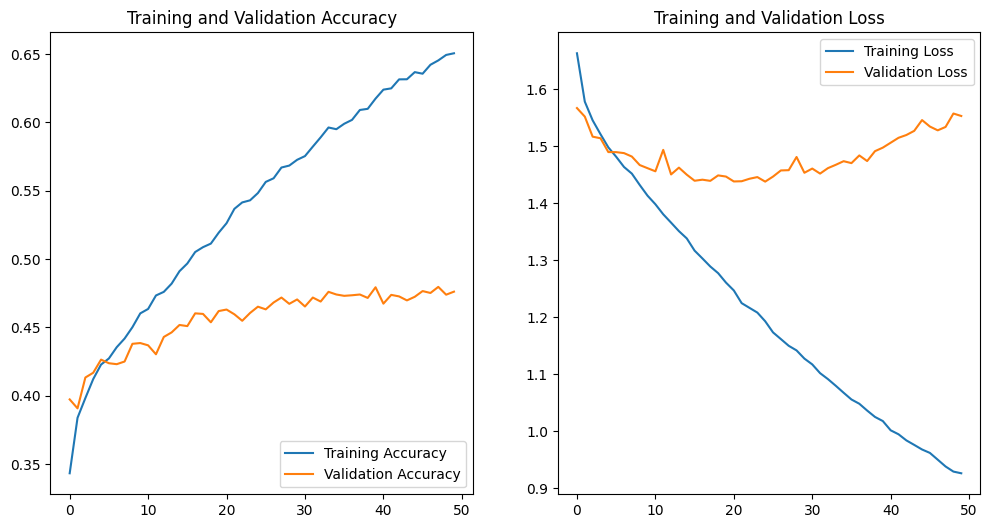

In [13]:
# Call the main function to start the training process
train_with_pretrained_model()